In [72]:
"""Pytorch."""
import nltk
import numpy as np
from numpy.typing import NDArray
import torch
from typing import List, Optional
from torch import nn
import matplotlib.pyplot as plt


FloatArray = NDArray[np.float64]


def onehot(vocabulary: List[Optional[str]], token: Optional[str]) -> FloatArray:
    """Generate the one-hot encoding for the provided token in the provided vocabulary."""
    embedding = np.zeros((len(vocabulary), 1))
    try:
        idx = vocabulary.index(token)
    except ValueError:
        idx = len(vocabulary) - 1
    embedding[idx, 0] = 1
    return embedding


def logit(x: FloatArray) -> FloatArray:
    """Compute logit (inverse sigmoid)."""
    return np.log(x) - np.log(1 - x)


def normalize(x: torch.Tensor) -> torch.Tensor:
    """Normalize vector so that it sums to 1."""
    return x / torch.sum(x)


def loss_fn(p: float) -> float:
    """Compute loss to maximize probability."""
    return -p


class Unigram(nn.Module):
    def __init__(self, V: int):
        super().__init__()

        # construct initial s - corresponds to uniform p
        s0 = logit(np.ones((V, 1)) / V)
        self.s = nn.Parameter(torch.tensor(s0.astype("float32")))

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        # convert s to proper distribution p
        p = normalize(torch.sigmoid(self.s))

        # compute log probability of input
        return torch.sum(input, 1, keepdim=True).T @ torch.log(p), p

In [102]:
def gradient_descent_example():
    """Demonstrate gradient descent."""
    # generate vocabulary
    vocabulary = [chr(i + ord("a")) for i in range(26)] + [" ", None]

    # generate training document
    text = nltk.corpus.gutenberg.raw("austen-sense.txt").lower()

    # tokenize - split the document into a list of little strings
    tokens = [char for char in text]

    # generate one-hot encodings - a V-by-T array
    encodings = np.hstack([onehot(vocabulary, token) for token in tokens])

    # convert training data to PyTorch tensor
    x = torch.tensor(encodings.astype("float32"))

    # define model

    model = Unigram(len(vocabulary))

    # set number of iterations and learning rate
    num_iterations = 100
    learning_rate = 0.1

    # train model
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    list_loss = []
    list_items = []
    for i in range(num_iterations):
        p_pred, p = model(x)
        loss = -p_pred
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()
        list_loss.append(i)
        list_items.append(loss.item())
    true_p = torch.sum(x, 1, keepdim=True) / len(text)
    mm = -(torch.sum(x, 1, keepdim=True)).T @ torch.log(true_p)
    min = mm.item()
    plt.plot(list_loss, list_items)
    plt.xlabel("iterations")
    plt.ylabel("loss")
    plt.title("Loss as a function of time ")
    plt.axhline(y=min, color="red", linestyle="--", label="Minimum possible loss")
    plt.legend()
    plt.show()
    return p, true_p

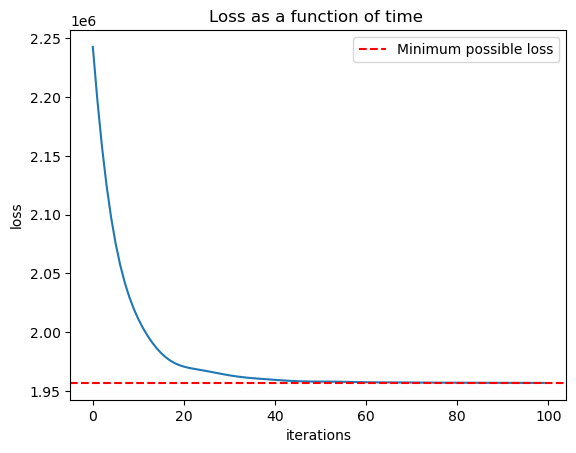

(tensor([[0.0601],
         [0.0119],
         [0.0185],
         [0.0332],
         [0.0985],
         [0.0182],
         [0.0141],
         [0.0479],
         [0.0543],
         [0.0014],
         [0.0041],
         [0.0307],
         [0.0218],
         [0.0571],
         [0.0623],
         [0.0119],
         [0.0011],
         [0.0494],
         [0.0487],
         [0.0667],
         [0.0219],
         [0.0085],
         [0.0188],
         [0.0013],
         [0.0174],
         [0.0008],
         [0.1609],
         [0.0582]], grad_fn=<DivBackward0>),
 tensor([[6.0096e-02],
         [1.1795e-02],
         [1.8488e-02],
         [3.3168e-02],
         [9.8970e-02],
         [1.8167e-02],
         [1.4193e-02],
         [4.7939e-02],
         [5.4269e-02],
         [1.4086e-03],
         [4.1306e-03],
         [3.0650e-02],
         [2.1718e-02],
         [5.7121e-02],
         [6.2427e-02],
         [1.1806e-02],
         [8.9744e-04],
         [4.9398e-02],
         [4.8694e-02],
     

In [103]:
gradient_descent_example()

In [80]:
2800 - 2773

27

The final token probabilities - comapare this to the (known) opitmal probabilities